# Introduction
* This program that classifies legal issues into a binary value for each National Subject Matter Index (NSMI). (https://nsmi.lsntap.org/browse-v2) \\
"Category" means 20 indexes. \\
"Class" means sub categories under the category.

### Data
* The data contains 2777 labeled articles. Each article has a binary value(0 or 1) that indicates if this article is related to a specific legal class. We ignore unlabeled entries when constructing a model.

### Implementation
* The program converts an article into tf-idf and applies multinomial Naive-Bayes model provided by scikit-learn. 

* After preprocessing data, we predict the model with 10-fold cross-validation.

### Output
* We calculate accuracy with bot categories(20) and classes(100+). \\

See overall result is at the bottom of this notebook.

# Data Preparation (DONE)

In [1]:
!pip3 install PrettyTable
!pip3 install pandas
!pip3 install sklearn
!pip3 install matplotlib
!pip3 install seaborn
!pip3 install tqdm
!pip3 install nltk
!python3 -m nltk.downloader stopwords punkt

import os
import sys
import pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
pd.options.display.max_rows = 100
pd.set_option('display.max_columns', None) 
print("DONE")

/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /Users/heeh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/heeh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/Users/heeh/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


DONE


In [2]:
url = 'https://raw.githubusercontent.com/heeh/legal_issue_classification/master/2019-12-06_95p-confidence_binary.csv'
df = pd.read_csv(url)
df.info()
df.iloc[:,:4]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2777 entries, 0 to 2776
Columns: 109 entries, _id to WO-09-00-00-00
dtypes: float64(107), object(2)
memory usage: 2.3+ MB


,_id,full_text,BE-00-00-00-00,BE-01-00-00-00
0,5b60e59cda52255c20cff794,Will he serve time?. Long story short my broth...,0.0,0.0
1,5b60e59cda52255c20cff79a,Groundwater leaking out of street 24/7. Ground...,0.0,0.0
2,5b60e59cda52255c20cff7a0,How do I get my mom's license taken away. My m...,0.0,0.0
3,5b60e59cda52255c20cff7bf,My boss hasn't paid me. What do i do?. I work ...,NaN,NaN
4,5b60e59cda52255c20cff7b8,"[Texas] I signed a non-compete contract, but t...",0.0,0.0
...,...,...,...,...
2772,5b60e66dda52255c20df433f,Do you and your parents get deported because o...,0.0,0.0
2773,5b60e66dda52255c20df43ae,Wondering the legality of a minor (me) being a...,0.0,0.0
2774,5b60e66dda52255c20df4462,Can I sue a billion dollar company in small cl...,0.0,0.0
2775,5b60e66dda52255c20df4448,Sued by creditor and currently in settlement n...,0.0,0.0


## Null and Rowsum Check

In [3]:

#Null Check
#df.isnull().sum()

# Class Check - Remove every column that has zero sum. 
df = df.loc[:, df.sum(axis=0, skipna=True) != 0]
temp = df.sum(axis = 0, skipna = True)


#df.info()


# Remove columns that have <10 positive classes

In [4]:
oldCols = list(df.columns)
print(len(oldCols))

newCols = []
for i,x in temp[2:].items():
    if x >= 10:
        newCols.append(i)
        
print(len(newCols))

cols = oldCols[:2] + newCols

print(cols)
print(len(cols))

df = df[cols]

df.sum(axis=0, skipna=True)

88
36
['_id', 'full_text', 'BE-00-00-00-00', 'BU-00-00-00-00', 'CO-00-00-00-00', 'CR-00-00-00-00', 'CR-01-00-00-00', 'CR-04-00-00-00', 'CR-06-00-00-00', 'CR-10-00-00-00', 'ED-00-00-00-00', 'ES-00-00-00-00', 'ES-01-00-00-00', 'ES-03-00-00-00', 'FA-00-00-00-00', 'FA-05-00-00-00', 'FA-06-00-00-00', 'FA-07-00-00-00', 'GO-00-00-00-00', 'HE-00-00-00-00', 'HO-00-00-00-00', 'HO-06-00-00-00', 'HO-09-00-00-00', 'IM-00-00-00-00', 'MO-00-00-00-00', 'MO-02-00-00-00', 'MO-07-00-00-00', 'MO-10-00-00-00', 'RI-00-00-00-00', 'TO-00-00-00-00', 'TR-00-00-00-00', 'TR-01-00-00-00', 'TR-02-00-00-00', 'TR-03-00-00-00', 'TR-04-00-00-00', 'TR-05-00-00-00', 'WO-00-00-00-00', 'WO-03-00-00-00']
38


_id               5b60e59cda52255c20cff7945b60e59cda52255c20cff7...
full_text         Will he serve time?. Long story short my broth...
BE-00-00-00-00                                                   27
BU-00-00-00-00                                                   93
CO-00-00-00-00                                                  106
CR-00-00-00-00                                                  302
CR-01-00-00-00                                                   12
CR-04-00-00-00                                                   13
CR-06-00-00-00                                                   11
CR-10-00-00-00                                                   11
ED-00-00-00-00                                                   24
ES-00-00-00-00                                                   78
ES-01-00-00-00                                                   10
ES-03-00-00-00                                                   13
FA-00-00-00-00                                  

# Tiny Example: Crime and Prison(CR-00-00-00-00)


## Preprocessing (DONE)

In [5]:
from collections import defaultdict
verbose = True
def preprocessing(dfset: defaultdict, cls: str):
    dfset[cls] = df.loc[:, ['_id', 'full_text', cls]]
    labels = dfset[cls].iloc[:,2]
    if verbose:
        print("------------Before dropping nan----------------------------------------")
        print(dfset[cls].iloc[:,1:])
        print(labels.value_counts(dropna=False))
    
    dfset[cls] = dfset[cls].dropna()
    labels = dfset[cls].iloc[:,2]
    if verbose:
        print("\n------------After dropping nan---------------------------------------")
        print(dfset[cls].iloc[:,1:])
        print(labels.value_counts(dropna=False))



## Data Preparation

In [6]:

cls = 'CR-00-00-00-00'
dfset = defaultdict() 
preprocessing(dfset, cls)    

#    model[cls] = make_pipeline(TfidfVectorizer(), MultinomialNB())
tinydf = dfset[cls]
X = tinydf['full_text'].values
Y = tinydf[cls].values


------------Before dropping nan----------------------------------------
                                              full_text  CR-00-00-00-00
0     Will he serve time?. Long story short my broth...             1.0
1     Groundwater leaking out of street 24/7. Ground...             0.0
2     How do I get my mom's license taken away. My m...             NaN
3     My boss hasn't paid me. What do i do?. I work ...             0.0
4     [Texas] I signed a non-compete contract, but t...             0.0
...                                                 ...             ...
2772  Do you and your parents get deported because o...             1.0
2773  Wondering the legality of a minor (me) being a...             0.0
2774  Can I sue a billion dollar company in small cl...             0.0
2775  Sued by creditor and currently in settlement n...             0.0
2776  (CA) Sales job. Income based on performance. A...             0.0

[2777 rows x 2 columns]
0.0    1377
NaN    1098
1.0     302
Nam

# TF-IDF

## TF-IDF using stopwords, ngram, and C value

In [7]:
import sys
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss, make_scorer
p = len(X) // 10 * 9
#tfidf_vect = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_df=300 )
tfidf_vect = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_df=0.3)
tfidf_vect.fit(X[0:p])
X_train_tfidf_vect = tfidf_vect.transform(X[0:p])
X_test_tfidf_vect = tfidf_vect.transform(X[p:])

model = LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced')
model.fit(X_train_tfidf_vect, Y[0:p])
preds = model.predict(X_test_tfidf_vect)
precision, recall, fscore, support = score(Y[p:], preds, average='binary')
print('accuracy : {0:.4f}'.format(accuracy_score(Y[p:], preds)))
print('precision: {0:.4f}'.format(precision))
print('recall   : {0:.4f}'.format(recall))
print('fscore   : {0:.4f}'.format(fscore))

print("TF-IDF Dimension: ", len(tfidf_vect.vocabulary_))


accuracy : 0.9148
precision: 0.6333
recall   : 0.8261
fscore   : 0.7170
TF-IDF Dimension:  127258


## Optimize model using gridsearch, cross validation, and log_loss

In [8]:
parameters = {'C': [1.0/2.0**reg for reg in np.arange(-12, 12)]}
lr = LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', max_iter=1000)
grid_search = GridSearchCV(lr, parameters, cv=10, refit=True, 
                           scoring=make_scorer(log_loss, greater_is_better=False))
grid_search.fit(X_train_tfidf_vect, Y[:p])
best_model = grid_search.best_estimator_
print(best_model)

preds = best_model.predict(X_test_tfidf_vect)
precision, recall, fscore, support = score(Y[p:], preds, average='binary')
print('accuracy : {0:.4f}'.format(accuracy_score(Y[p:], preds)))
print('precision: {0:.4f}'.format(precision))
print('recall   : {0:.4f}'.format(recall))
print('fscore   : {0:.4f}'.format(fscore))

LogisticRegression(C=2048.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
accuracy : 0.9375
precision: 0.7727
recall   : 0.7391
fscore   : 0.7556


## TF-IDF + Logistic Regression on CR-00-00-00-00

In [9]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.linear_model import LogisticRegression

def predict_by_class_tfidf(dfset: defaultdict,cls: str, model) -> float:
    preprocessing(dfset, cls)
    tinydf = dfset[cls]
    X = tinydf['full_text'].values
    Y = tinydf[cls].values
    print('------------------------------------\n')
    labels = dfset[cls].iloc[:,2]
    print(labels.value_counts(dropna=False))

    kfold = KFold(n_splits=10)
    print('data set size', len(X))
    numdoc[cls] = len(X)
    n_iter = 0
    acc_list = []
    pre_list = []
    rec_list = []
    fsc_list = []
    sup_list = []
    preds = [0] * len(Y)

    for train_index, test_index in kfold.split(X, Y):
        X_train, X_test = X[train_index], X[test_index] 
        Y_train, Y_test = Y[train_index], Y[test_index] 
        
        tfidf_vect = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_df=0.3)
        tfidf_vect.fit(X_train)
        X_train_tfidf = tfidf_vect.transform(X_train)
        X_test_tfidf = tfidf_vect.transform(X_test)
        
        model.fit(X_train_tfidf, Y_train)
        out = model.predict(X_test_tfidf)
        i = 0
        for x in test_index:
            preds[x] = out[i]
            i += 1
        n_iter += 1
        
    accuracy = accuracy_score(Y, preds)
    precision, recall, fscore, support = score(Y, preds)
    # accuracy: (tp + tn) / (p + n)
    # precision tp / (tp + fp)
    # recall: tp / (tp + fn)
    # f1: 2 tp / (2 tp + fp + fn)
    accuracy = np.round(accuracy, 4)
    precision[1] = np.round(precision[1], 4)
    recall[1] = np.round(recall[1], 4)
    fscore[1] = np.round(fscore[1], 4)
    support[1] = np.round(support[1], 4)    
    return (accuracy, precision[1], recall[1], fscore[1], support[1])

verbose = False 
numdoc = defaultdict()
model = LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', max_iter=1000)
cls = 'CR-00-00-00-00'

predict_by_class_tfidf(dfset, cls, model)

------------------------------------

0.0    1377
1.0     302
Name: CR-00-00-00-00, dtype: int64
data set size 1679


(0.8886, 0.6667, 0.7616, 0.711, 302)

## TFIDF Hyperparameter Selection 

In [10]:
from tqdm import tqdm

classifier = defaultdict()


def predict_by_class_gridcv(dfset: defaultdict,cls: str):
    preprocessing(dfset, cls)
    tinydf = dfset[cls]
    X = tinydf['full_text'].values
    Y = tinydf[cls].values
    print('------------------------------------\n')
    labels = dfset[cls].iloc[:,2]
    print(labels.value_counts(dropna=False))

    kfold = KFold(n_splits=10)
    print('data set size', len(X))
    numdoc[cls] = len(X)
    n_iter = 0
    acc_list = []
    pre_list = []
    rec_list = []
    fsc_list = []
    sup_list = []
    preds = [0] * len(Y)
    probs = [0] * len(Y)
    
    best_recall = 0
    best_accuracy = 0
    best_precision = 0
    best_fscore = 0
    best_support = 0
    best_model = 0
    
    best_logloss = 1
    
    for c in tqdm([1.0/2.0**reg for reg in np.arange(-12, 12)]):
        print('C:', c)
        model = LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', C = c)
    
        for train_index, test_index in kfold.split(X, Y):
            X_train, X_test = X[train_index], X[test_index] 
            Y_train, Y_test = Y[train_index], Y[test_index] 

            tfidf_vect = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_df=0.3)
            tfidf_vect.fit(X_train)
            X_train_tfidf = tfidf_vect.transform(X_train)
            X_test_tfidf = tfidf_vect.transform(X_test)

            model.fit(X_train_tfidf, Y_train)
            out = model.predict(X_test_tfidf)
            prob = model.predict_proba(X_test_tfidf)
            i = 0
            for x in test_index:
                preds[x] = out[i]
                probs[x] = prob[i]
                i += 1
            n_iter += 1

        
        custom_logloss = log_loss(Y, probs)
        print(custom_logloss)
        
        
        
        
        accuracy = accuracy_score(Y, preds)
        precision, recall, fscore, support = score(Y, preds)
        # accuracy: (tp + tn) / (p + n)
        # precision tp / (tp + fp)
        # recall: tp / (tp + fn)
        # f1: 2 tp / (2 tp + fp + fn)
        accuracy = np.round(accuracy, 4)
        precision[1] = np.round(precision[1], 4)
        recall[1] = np.round(recall[1], 4)
        fscore[1] = np.round(fscore[1], 4)
        support[1] = np.round(support[1], 4)    
#        print(accuracy, precision[1], recall[1], fscore[1], support[1])
        
        #if best_recall < recall[1]: #For best recall score
        if best_logloss > custom_logloss: 
            best_logloss = custom_logloss
            best_accuracy = accuracy
            best_recall = recall[1]
            best_precision = precision[1]
            best_fscore = fscore[1]
            best_support = support[1]
            best_model = model
            
    classifier[cls] = best_model
    return (best_accuracy, best_precision, best_recall, best_fscore, best_support)


numdoc = defaultdict()

cls = 'CR-00-00-00-00'

#print(predict_by_class_gridcv(dfset, cls))

# GloVE

## Download and Load GloVe

In [11]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove.6B.zip
import numpy as np
import pandas as pd


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack



from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import punkt
stop_words = stopwords.words('english')
from tqdm import tqdm

import sys
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss, make_scorer



embeddings_index = {}
f = open('glove.6B.50d.txt', encoding="utf8")
for line in tqdm(f):
    values = line.split()
    word = values[0]
    try:
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except ValueError:
        pass
f.close()
print('Found %s word vectors.' % len(embeddings_index))

400000it [00:05, 74883.96it/s]

Found 400000 word vectors.


## GloVe Train & Predict

In [12]:
cls = 'CR-00-00-00-00'



# Train and Test Split
p = len(X) // 10 * 9
train_text = X[:p]
test_text = X[p:]


print("Checkpoint1 - Data Read Complete")


hit = 0
all_words = 0
# this function creates a normalized vector for the whole sentence
def sent2vec(s):
    global hit, all_words
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    hit += len(M)
    all_words += len(words)
    
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

# create sentence vectors using the above function for training and validation set
xtrain_glove = [sent2vec(x) for x in tqdm(train_text)]

print('Mean Train Word Hit Rate(\%)', hit / all_words * 100)
hit = 0
all_words = 0

xtest_glove = [sent2vec(x) for x in tqdm(test_text)]
print('Mean Test Word Hit Rate(\%)', hit / all_words * 100)

print('Checkpoint2 -Normalized Vector for Sentences are created')

xtrain_glove = np.array(xtrain_glove)
xtest_glove = np.array(xtest_glove)

model = LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced')

train_target = Y[:p]
test_target = Y[p:]

model.fit(xtrain_glove, train_target)
preds = model.predict(xtest_glove)

print(preds)
accuracy = accuracy_score(test_target, preds)
precision, recall, fscore, support = score(test_target, preds)
print('accuracy: {}'.format(accuracy))
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

  3%|▎         | 49/1503 [00:00<00:03, 481.38it/s]

Checkpoint1 - Data Read Complete


 27%|██▋       | 48/176 [00:00<00:00, 475.92it/s]

Mean Train Word Hit Rate(\%) 99.58181372991224


100%|██████████| 176/176 [00:00<00:00, 544.17it/s]


Mean Test Word Hit Rate(\%) 99.61077662227088
Checkpoint2 -Normalized Vector for Sentences are created
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1.
 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0.
 0. 0. 0. 1. 0. 0. 0. 0.]
accuracy: 0.875
precision: [0.9924812  0.51162791]
recall: [0.8627451  0.95652174]
fscore: [0.92307692 0.66666667]
support: [153  23]


## GloVE + Logistic Regression on CR-00-00-00-00

In [22]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer

verbose = False
    
numdoc = defaultdict()

classifier = defaultdict()

    
def predict_by_class_glove(dfset: defaultdict,cls: str) -> float:
    preprocessing(dfset, cls)
    tinydf = dfset[cls]
    X = tinydf['full_text'].values
    Y = tinydf[cls].values
    X_glove = [sent2vec(x) for x in tqdm(X)]
    X_glove = np.array(X_glove)

    print('------------------------------------\n')
    labels = dfset[cls].iloc[:,2]
    print(labels.value_counts(dropna=False))

    # 10-fold separation with train and test 
    #kfold = KFold(n_splits=10)
    kfold = KFold(n_splits=10)
    print('data set size', len(X))
    numdoc[cls] = len(X)
    n_iter = 0
    acc_list = []
    pre_list = []
    rec_list = []
    fsc_list = []
    sup_list = []

    
    preds = [0] * len(Y)
    probs = [0] * len(Y)
    
    print('Checkpoint2 -Normalized Vector for Sentences are created')
    


    for train_index, test_index in kfold.split(X_glove, Y):

        X_train, X_test = X_glove[train_index], X_glove[test_index] 
        Y_train, Y_test = Y[train_index], Y[test_index]

        # Scikit-Learn
        classifier[cls] = LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', max_iter=1000)
        classifier[cls].fit(X_train, Y_train)
        out = classifier[cls].predict(X_test)
        prob = classifier[cls].predict_proba(X_test)
        
        

        #print(len(out))
        i = 0
        for x in test_index:
            preds[x] = out[i]
            probs[x] = prob[i]
            i += 1
            
        #print(preds)

        n_iter += 1
        
    
    custom_logloss = np.round(log_loss(Y, probs), 4)
    print(custom_logloss)
    
    accuracy = accuracy_score(Y, preds)
    precision, recall, fscore, support = score(Y, preds)
    # accuracy: (tp + tn) / (p + n)
    # precision tp / (tp + fp)
    # recall:   tp / (tp + fn)
    # f1: 2 tp / (2 tp + fp + fn)
    accuracy = np.round(accuracy, 4)
    precision[1] = np.round(precision[1], 4)
    recall[1] = np.round(recall[1], 4)
    fscore[1] = np.round(fscore[1], 4)
    support[1] = np.round(support[1], 4)
    
    
    return (accuracy, precision[1], recall[1], fscore[1], support[1], custom_logloss)



#cls = 'BE-00-00-00-00'
cls = 'CR-00-00-00-00'
predict_by_class_glove(dfset, cls)

100%|██████████| 1679/1679 [00:03<00:00, 523.38it/s]


------------------------------------

0.0    1377
1.0     302
Name: CR-00-00-00-00, dtype: int64
data set size 1679
Checkpoint2 -Normalized Vector for Sentences are created
0.3465


(0.8582, 0.5717, 0.8444, 0.6818, 302, 0.3465)

## GloVe GridSearch

In [14]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer

verbose = False
numdoc = defaultdict()
classifier = defaultdict()

    
def predict_by_class_glove_grid(dfset: defaultdict,cls: str) -> float:
    preprocessing(dfset, cls)
    tinydf = dfset[cls]
    X = tinydf['full_text'].values
    Y = tinydf[cls].values
    X_glove = [sent2vec(x) for x in tqdm(X)]
    X_glove = np.array(X_glove)

    print('------------------------------------\n')
    labels = dfset[cls].iloc[:,2]
    print(labels.value_counts(dropna=False))
    kfold = KFold(n_splits=10)
    print('data set size', len(X))
    numdoc[cls] = len(X)
    n_iter = 0
    acc_list = []
    pre_list = []
    rec_list = []
    fsc_list = []
    sup_list = []

    
    preds = [0] * len(Y)
    probs = [0] * len(Y)

    best_recall = 0
    best_accuracy = 0
    best_precision = 0
    best_fscore = 0
    best_support = 0
    best_model = 0
    
    best_logloss = 1
    
    model = None

    for c in tqdm([1.0/2.0**reg for reg in np.arange(-12, 12)]):
        print('C:', c)
        model = LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', max_iter=1000, C = c)
        
        for train_index, test_index in tqdm(kfold.split(X_glove, Y)):
            X_train, X_test = X_glove[train_index], X_glove[test_index] 
            Y_train, Y_test = Y[train_index], Y[test_index]
            model.fit(X_train, Y_train)
            out = model.predict(X_test)
            prob = model.predict_proba(X_test)

            i = 0
            for x in test_index:
                preds[x] = out[i]
                probs[x] = prob[i]
                i += 1
            n_iter += 1

            
            
        custom_logloss = log_loss(Y, probs)
        print(custom_logloss)

        accuracy = accuracy_score(Y, preds)
        precision, recall, fscore, support = score(Y, preds)
        # accuracy: (tp + tn) / (p + n)
        # precision tp / (tp + fp)
        # recall:   tp / (tp + fn)
        # f1: 2 tp / (2 tp + fp + fn)
        accuracy = np.round(accuracy, 4)
        precision[1] = np.round(precision[1], 4)
        recall[1] = np.round(recall[1], 4)
        fscore[1] = np.round(fscore[1], 4)
        support[1] = np.round(support[1], 4)


#        if best_recall < recall[1]:
        if best_logloss > custom_logloss:
            best_logloss = custom_logloss
            
            best_accuracy = accuracy
            best_recall = recall[1]
            best_precision = precision[1]
            best_fscore = fscore[1]
            best_support = support[1]
            best_model = model
            
    classifier[cls] = best_model
    return (best_accuracy, best_precision, best_recall, best_fscore, best_support)

cls = 'CR-00-00-00-00'
#print(predict_by_class_glove_grid(dfset, cls))

# Entire Data 

## Build Models and Calculating Accuracies

In [23]:
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

class_list = df.columns[2:]
print(class_list)
verbose = False
stat_dict = defaultdict() 
for cls in tqdm(class_list):
    preprocessing(dfset, cls)
    ret = predict_by_class_glove(dfset, cls)
#    ret = predict_by_class_gridcv(dfset, cls)
    stat_dict[cls] = ret 
    print('statistics' , ret)

  3%|▎         | 47/1848 [00:00<00:03, 463.25it/s]

Index(['BE-00-00-00-00', 'BU-00-00-00-00', 'CO-00-00-00-00', 'CR-00-00-00-00',
       'CR-01-00-00-00', 'CR-04-00-00-00', 'CR-06-00-00-00', 'CR-10-00-00-00',
       'ED-00-00-00-00', 'ES-00-00-00-00', 'ES-01-00-00-00', 'ES-03-00-00-00',
       'FA-00-00-00-00', 'FA-05-00-00-00', 'FA-06-00-00-00', 'FA-07-00-00-00',
       'GO-00-00-00-00', 'HE-00-00-00-00', 'HO-00-00-00-00', 'HO-06-00-00-00',
       'HO-09-00-00-00', 'IM-00-00-00-00', 'MO-00-00-00-00', 'MO-02-00-00-00',
       'MO-07-00-00-00', 'MO-10-00-00-00', 'RI-00-00-00-00', 'TO-00-00-00-00',
       'TR-00-00-00-00', 'TR-01-00-00-00', 'TR-02-00-00-00', 'TR-03-00-00-00',
       'TR-04-00-00-00', 'TR-05-00-00-00', 'WO-00-00-00-00', 'WO-03-00-00-00'],
      dtype='object')



100%|██████████| 1848/1848 [00:03<00:00, 495.47it/s]


------------------------------------

0.0    1821
1.0      27
Name: BE-00-00-00-00, dtype: int64
data set size 1848
Checkpoint2 -Normalized Vector for Sentences are created


  3%|▎         | 43/1590 [00:00<00:03, 426.24it/s]

0.2951
statistics (0.8761, 0.0861, 0.7778, 0.155, 27, 0.2951)



100%|██████████| 1590/1590 [00:03<00:00, 489.08it/s]


------------------------------------

0.0    1497
1.0      93
Name: BU-00-00-00-00, dtype: int64
data set size 1590
Checkpoint2 -Normalized Vector for Sentences are created


  4%|▍         | 47/1164 [00:00<00:02, 460.85it/s]

0.2169
statistics (0.9277, 0.4421, 0.9032, 0.5936, 93, 0.2169)



100%|██████████| 1164/1164 [00:02<00:00, 498.81it/s]


------------------------------------

0.0    1058
1.0     106
Name: CO-00-00-00-00, dtype: int64
data set size 1164
Checkpoint2 -Normalized Vector for Sentences are created


  3%|▎         | 52/1679 [00:00<00:03, 510.79it/s]

0.3644
statistics (0.8703, 0.3923, 0.7736, 0.5206, 106, 0.3644)



100%|██████████| 1679/1679 [00:03<00:00, 503.27it/s]


------------------------------------

0.0    1377
1.0     302
Name: CR-00-00-00-00, dtype: int64
data set size 1679
Checkpoint2 -Normalized Vector for Sentences are created


  3%|▎         | 44/1393 [00:00<00:03, 398.79it/s]

0.3465
statistics (0.8582, 0.5717, 0.8444, 0.6818, 302, 0.3465)



100%|██████████| 1393/1393 [00:02<00:00, 507.59it/s]


------------------------------------

0.0    1381
1.0      12
Name: CR-01-00-00-00, dtype: int64
data set size 1393
Checkpoint2 -Normalized Vector for Sentences are created


  3%|▎         | 44/1402 [00:00<00:03, 388.45it/s]

0.3339
statistics (0.8622, 0.0161, 0.25, 0.0303, 12, 0.3339)



100%|██████████| 1402/1402 [00:02<00:00, 509.63it/s]


------------------------------------

0.0    1389
1.0      13
Name: CR-04-00-00-00, dtype: int64
data set size 1402
Checkpoint2 -Normalized Vector for Sentences are created


  3%|▎         | 44/1404 [00:00<00:03, 405.61it/s]

0.3722
statistics (0.8559, 0.0299, 0.4615, 0.0561, 13, 0.3722)



100%|██████████| 1404/1404 [00:02<00:00, 508.46it/s]


------------------------------------

0.0    1393
1.0      11
Name: CR-06-00-00-00, dtype: int64
data set size 1404
Checkpoint2 -Normalized Vector for Sentences are created


  3%|▎         | 53/1969 [00:00<00:03, 518.57it/s]

0.2744
statistics (0.8917, 0.0331, 0.4545, 0.0617, 11, 0.2744)



100%|██████████| 1969/1969 [00:03<00:00, 505.16it/s]


------------------------------------

0.0    1958
1.0      11
Name: CR-10-00-00-00, dtype: int64
data set size 1969
Checkpoint2 -Normalized Vector for Sentences are created


  3%|▎         | 49/1813 [00:00<00:04, 402.86it/s]

0.2691
statistics (0.8913, 0.0144, 0.2727, 0.0273, 11, 0.2691)



100%|██████████| 1813/1813 [00:03<00:00, 487.29it/s]


------------------------------------

0.0    1789
1.0      24
Name: ED-00-00-00-00, dtype: int64
data set size 1813
Checkpoint2 -Normalized Vector for Sentences are created


  3%|▎         | 52/1944 [00:00<00:03, 516.48it/s]

0.2142
statistics (0.9338, 0.1308, 0.7083, 0.2208, 24, 0.2142)



100%|██████████| 1944/1944 [00:03<00:00, 500.25it/s]


------------------------------------

0.0    1866
1.0      78
Name: ES-00-00-00-00, dtype: int64
data set size 1944
Checkpoint2 -Normalized Vector for Sentences are created


  3%|▎         | 56/1876 [00:00<00:03, 555.40it/s]

0.2675
statistics (0.8904, 0.2433, 0.8205, 0.3754, 78, 0.2675)



100%|██████████| 1876/1876 [00:03<00:00, 502.95it/s]


------------------------------------

0.0    1866
1.0      10
Name: ES-01-00-00-00, dtype: int64
data set size 1876
Checkpoint2 -Normalized Vector for Sentences are created


  3%|▎         | 53/1992 [00:00<00:03, 523.96it/s]

0.1872
statistics (0.9264, 0.0362, 0.5, 0.0676, 10, 0.1872)



100%|██████████| 1992/1992 [00:03<00:00, 502.43it/s]


------------------------------------

0.0    1979
1.0      13
Name: ES-03-00-00-00, dtype: int64
data set size 1992
Checkpoint2 -Normalized Vector for Sentences are created


  3%|▎         | 53/2042 [00:00<00:03, 509.69it/s]

0.2653
statistics (0.88, 0.0292, 0.5385, 0.0553, 13, 0.2653)



100%|██████████| 2042/2042 [00:04<00:00, 494.19it/s]


------------------------------------

0.0    1685
1.0     357
Name: FA-00-00-00-00, dtype: int64
data set size 2042
Checkpoint2 -Normalized Vector for Sentences are created


  3%|▎         | 56/2011 [00:00<00:03, 550.99it/s]

0.3053
statistics (0.8869, 0.626, 0.8768, 0.7305, 357, 0.3053)



100%|██████████| 2011/2011 [00:04<00:00, 502.66it/s]


------------------------------------

0.0    2001
1.0      10
Name: FA-05-00-00-00, dtype: int64
data set size 2011
Checkpoint2 -Normalized Vector for Sentences are created


  3%|▎         | 55/1791 [00:00<00:03, 547.49it/s]

0.246
statistics (0.9035, 0.0306, 0.6, 0.0583, 10, 0.246)



100%|██████████| 1791/1791 [00:03<00:00, 503.32it/s]


------------------------------------

0.0    1781
1.0      10
Name: FA-06-00-00-00, dtype: int64
data set size 1791
Checkpoint2 -Normalized Vector for Sentences are created


  3%|▎         | 53/1968 [00:00<00:03, 513.32it/s]

0.2615
statistics (0.8984, 0.0275, 0.5, 0.0521, 10, 0.2615)



100%|██████████| 1968/1968 [00:03<00:00, 504.04it/s]


------------------------------------

0.0    1927
1.0      41
Name: FA-07-00-00-00, dtype: int64
data set size 1968
Checkpoint2 -Normalized Vector for Sentences are created


  3%|▎         | 41/1517 [00:00<00:03, 405.37it/s]

0.392
statistics (0.8166, 0.0745, 0.6829, 0.1343, 41, 0.392)



100%|██████████| 1517/1517 [00:03<00:00, 486.36it/s]


------------------------------------

0.0    1504
1.0      13
Name: GO-00-00-00-00, dtype: int64
data set size 1517
Checkpoint2 -Normalized Vector for Sentences are created


  3%|▎         | 55/1900 [00:00<00:03, 524.71it/s]

0.3374
statistics (0.8662, 0.0103, 0.1538, 0.0193, 13, 0.3374)



100%|██████████| 1900/1900 [00:03<00:00, 500.40it/s]


------------------------------------

0.0    1778
1.0     122
Name: HE-00-00-00-00, dtype: int64
data set size 1900
Checkpoint2 -Normalized Vector for Sentences are created


  3%|▎         | 56/2132 [00:00<00:03, 557.14it/s]

0.2289
statistics (0.9316, 0.4825, 0.9016, 0.6286, 122, 0.2289)



100%|██████████| 2132/2132 [00:04<00:00, 490.21it/s]


------------------------------------

0.0    1582
1.0     550
Name: HO-00-00-00-00, dtype: int64
data set size 2132
Checkpoint2 -Normalized Vector for Sentences are created


  3%|▎         | 50/1662 [00:00<00:03, 499.87it/s]

0.2645
statistics (0.9128, 0.7935, 0.8945, 0.841, 550, 0.2645)



100%|██████████| 1662/1662 [00:03<00:00, 510.23it/s]


------------------------------------

0.0    1628
1.0      34
Name: HO-06-00-00-00, dtype: int64
data set size 1662
Checkpoint2 -Normalized Vector for Sentences are created


  3%|▎         | 56/1653 [00:00<00:02, 548.91it/s]

0.315
statistics (0.8935, 0.1295, 0.7353, 0.2203, 34, 0.315)



100%|██████████| 1653/1653 [00:03<00:00, 512.59it/s]


------------------------------------

0.0    1626
1.0      27
Name: HO-09-00-00-00, dtype: int64
data set size 1653
Checkpoint2 -Normalized Vector for Sentences are created


  3%|▎         | 56/1964 [00:00<00:03, 557.44it/s]

0.239
statistics (0.9226, 0.1469, 0.7778, 0.2471, 27, 0.239)



100%|██████████| 1964/1964 [00:03<00:00, 498.76it/s]


------------------------------------

0.0    1928
1.0      36
Name: IM-00-00-00-00, dtype: int64
data set size 1964
Checkpoint2 -Normalized Vector for Sentences are created


  3%|▎         | 46/1429 [00:00<00:03, 442.32it/s]

0.2065
statistics (0.9333, 0.1854, 0.7778, 0.2995, 36, 0.2065)



100%|██████████| 1429/1429 [00:02<00:00, 504.32it/s]


------------------------------------

0.0    1063
1.0     366
Name: MO-00-00-00-00, dtype: int64
data set size 1429
Checkpoint2 -Normalized Vector for Sentences are created


  3%|▎         | 56/1949 [00:00<00:03, 550.76it/s]

0.4226
statistics (0.8258, 0.6206, 0.8224, 0.7074, 366, 0.4226)



100%|██████████| 1949/1949 [00:03<00:00, 506.82it/s]


------------------------------------

0.0    1937
1.0      12
Name: MO-02-00-00-00, dtype: int64
data set size 1949
Checkpoint2 -Normalized Vector for Sentences are created


  4%|▍         | 47/1129 [00:00<00:02, 461.47it/s]

0.2327
statistics (0.9174, 0.0429, 0.5833, 0.08, 12, 0.2327)



100%|██████████| 1129/1129 [00:02<00:00, 518.65it/s]


------------------------------------

0.0    1116
1.0      13
Name: MO-07-00-00-00, dtype: int64
data set size 1129
Checkpoint2 -Normalized Vector for Sentences are created


  4%|▍         | 45/1106 [00:00<00:02, 445.66it/s]

0.2485
statistics (0.9176, 0.0918, 0.6923, 0.1622, 13, 0.2485)



100%|██████████| 1106/1106 [00:02<00:00, 525.30it/s]


------------------------------------

0.0    1095
1.0      11
Name: MO-10-00-00-00, dtype: int64
data set size 1106
Checkpoint2 -Normalized Vector for Sentences are created


  3%|▎         | 42/1396 [00:00<00:03, 408.55it/s]

0.3188
statistics (0.8662, 0.021, 0.2727, 0.039, 11, 0.3188)



100%|██████████| 1396/1396 [00:02<00:00, 501.58it/s]


------------------------------------

0.0    1374
1.0      22
Name: RI-00-00-00-00, dtype: int64
data set size 1396
Checkpoint2 -Normalized Vector for Sentences are created


  4%|▎         | 44/1257 [00:00<00:02, 438.12it/s]

0.4229
statistics (0.8001, 0.0394, 0.5, 0.0731, 22, 0.4229)



  0%|          | 0/2006 [00:00<?, ?it/s]

------------------------------------

0.0    1027
1.0     230
Name: TO-00-00-00-00, dtype: int64
data set size 1257
Checkpoint2 -Normalized Vector for Sentences are created
0.4034
statistics (0.8218, 0.5083, 0.8, 0.6216, 230, 0.4034)



100%|██████████| 2006/2006 [00:04<00:00, 500.39it/s]


------------------------------------

0.0    1746
1.0     260
Name: TR-00-00-00-00, dtype: int64
data set size 2006
Checkpoint2 -Normalized Vector for Sentences are created


  3%|▎         | 53/1827 [00:00<00:03, 528.41it/s]

0.2269
statistics (0.9297, 0.6695, 0.9038, 0.7692, 260, 0.2269)



100%|██████████| 1827/1827 [00:03<00:00, 498.36it/s]


------------------------------------

0.0    1805
1.0      22
Name: TR-01-00-00-00, dtype: int64
data set size 1827
Checkpoint2 -Normalized Vector for Sentences are created


  3%|▎         | 49/1819 [00:00<00:03, 483.85it/s]

0.2149
statistics (0.9267, 0.1216, 0.8182, 0.2118, 22, 0.2149)



100%|██████████| 1819/1819 [00:03<00:00, 488.91it/s]


------------------------------------

0.0    1790
1.0      29
Name: TR-02-00-00-00, dtype: int64
data set size 1819
Checkpoint2 -Normalized Vector for Sentences are created


  3%|▎         | 53/1821 [00:00<00:03, 513.81it/s]

0.2701
statistics (0.9021, 0.1058, 0.6897, 0.1835, 29, 0.2701)



100%|██████████| 1821/1821 [00:03<00:00, 499.81it/s]


------------------------------------

0.0    1804
1.0      17
Name: TR-03-00-00-00, dtype: int64
data set size 1821
Checkpoint2 -Normalized Vector for Sentences are created


  3%|▎         | 55/1815 [00:00<00:03, 543.95it/s]

0.2104
statistics (0.9308, 0.084, 0.6471, 0.1486, 17, 0.2104)



100%|██████████| 1815/1815 [00:03<00:00, 498.91it/s]


------------------------------------

0.0    1795
1.0      20
Name: TR-04-00-00-00, dtype: int64
data set size 1815
Checkpoint2 -Normalized Vector for Sentences are created


  3%|▎         | 55/1816 [00:00<00:03, 541.92it/s]

0.1832
statistics (0.9433, 0.1391, 0.8, 0.237, 20, 0.1832)



100%|██████████| 1816/1816 [00:03<00:00, 491.45it/s]


------------------------------------

0.0    1785
1.0      31
Name: TR-05-00-00-00, dtype: int64
data set size 1816
Checkpoint2 -Normalized Vector for Sentences are created


  3%|▎         | 52/1991 [00:00<00:03, 518.66it/s]

0.1727
statistics (0.9466, 0.2203, 0.8387, 0.349, 31, 0.1727)



100%|██████████| 1991/1991 [00:04<00:00, 487.12it/s]


------------------------------------

0.0    1604
1.0     387
Name: WO-00-00-00-00, dtype: int64
data set size 1991
Checkpoint2 -Normalized Vector for Sentences are created


  3%|▎         | 52/1617 [00:00<00:03, 519.85it/s]

0.3673
statistics (0.8564, 0.5927, 0.8346, 0.6931, 387, 0.3673)



100%|██████████| 1617/1617 [00:03<00:00, 493.38it/s]


------------------------------------

0.0    1607
1.0      10
Name: WO-03-00-00-00, dtype: int64
data set size 1617
Checkpoint2 -Normalized Vector for Sentences are created


100%|██████████| 36/36 [05:00<00:00,  8.34s/it]

0.3207
statistics (0.8615, 0.0046, 0.1, 0.0088, 10, 0.3207)


## Distribution

In [24]:
!python3 -m pip install prettytable
from prettytable import PrettyTable
t = PrettyTable(["class", "accuracy", "precision", "recall", "F1 score", "support", "log_loss", "|documents|"])
#t.align["class"] = "r"
t.align["accuracy"] = "r"
t.align["precision"] = "r"
t.align["recall"] = "r"
t.align["F1 score"] = "r"
t.align["support"] = "r"
for k,v in stat_dict.items():
    t.add_row([k, v[0], v[1], v[2], v[3], v[4], v[5], numdoc[k]])
    
print(t)

+----------------+----------+-----------+--------+----------+---------+----------+-------------+
|     class      | accuracy | precision | recall | F1 score | support | log_loss | |documents| |
+----------------+----------+-----------+--------+----------+---------+----------+-------------+
| BE-00-00-00-00 |   0.8761 |    0.0861 | 0.7778 |    0.155 |      27 |  0.2951  |     1848    |
| BU-00-00-00-00 |   0.9277 |    0.4421 | 0.9032 |   0.5936 |      93 |  0.2169  |     1590    |
| CO-00-00-00-00 |   0.8703 |    0.3923 | 0.7736 |   0.5206 |     106 |  0.3644  |     1164    |
| CR-00-00-00-00 |   0.8582 |    0.5717 | 0.8444 |   0.6818 |     302 |  0.3465  |     1679    |
| CR-01-00-00-00 |   0.8622 |    0.0161 |   0.25 |   0.0303 |      12 |  0.3339  |     1393    |
| CR-04-00-00-00 |   0.8559 |    0.0299 | 0.4615 |   0.0561 |      13 |  0.3722  |     1402    |
| CR-06-00-00-00 |   0.8917 |    0.0331 | 0.4545 |   0.0617 |      11 |  0.2744  |     1404    |
| CR-10-00-00-00 |   0.8913 | 

## Plotting for Top10 classes

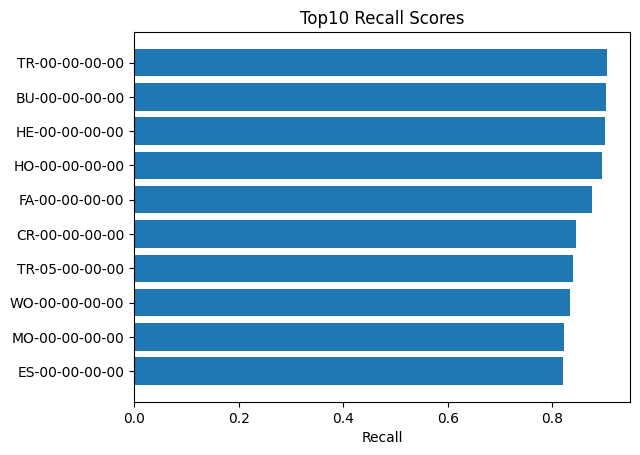

In [25]:
#for k,v in accuracy_dict.items():
#    print(k,v)
#sys.exit()
import collections
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
y_pos = np.arange(10)
error = 0 

recall_dict = defaultdict()
for k,v in stat_dict.items():
    recall_dict[k] = v[2]

sorted_x = sorted(recall_dict.items(), key=lambda kv: kv[1], reverse=True)
topcat_dict = collections.OrderedDict(sorted_x)
#print(topcat_dict)

keyList = []
valList = []
for kv in topcat_dict.items():
    keyList.append(kv[0])
    valList.append(kv[1])

ax.barh(y_pos[:10], valList[:10], xerr=error, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(keyList[:10])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Recall')
ax.set_title('Top10 Recall Scores')

plt.show()

## Bottom 10

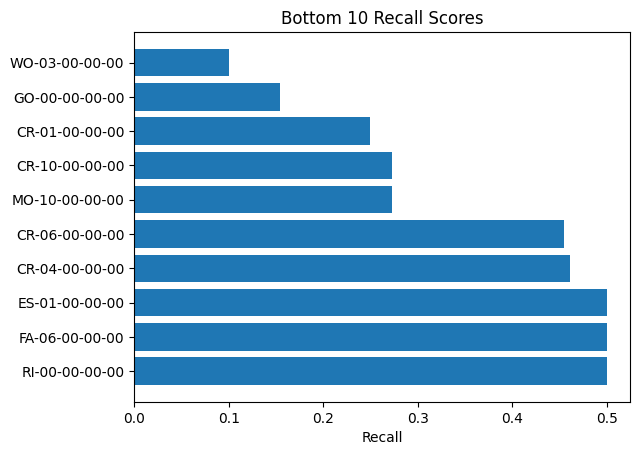

In [26]:
#for k,v in accuracy_dict.items():
#    print(k,v)
#sys.exit()
import collections
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
y_pos = np.arange(10)
error = 0 

recall_dict = defaultdict()
for k,v in stat_dict.items():
    recall_dict[k] = v[2]
    
sorted_x = sorted(recall_dict.items(), key=lambda kv: kv[1])
topcat_dict = collections.OrderedDict(sorted_x)
#print(topcat_dict)

keyList = []
valList = []
for kv in topcat_dict.items():
    keyList.append(kv[0])
    valList.append(kv[1])




ax.barh(y_pos[:10], valList[:10], xerr=error, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(keyList[:10])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Recall')
ax.set_title('Bottom 10 Recall Scores')

plt.show()

## Recall Distribution

    Recall
0    77.78
1    90.32
2    77.36
3    84.44
4    25.00
5    46.15
6    45.45
7    27.27
8    70.83
9    82.05
10   50.00
11   53.85
12   87.68
13   60.00
14   50.00
15   68.29
16   15.38
17   90.16
18   89.45
19   73.53
20   77.78
21   77.78
22   82.24
23   58.33
24   69.23
25   27.27
26   50.00
27   80.00
28   90.38
29   81.82
30   68.97
31   64.71
32   80.00
33   83.87
34   83.46
35   10.00


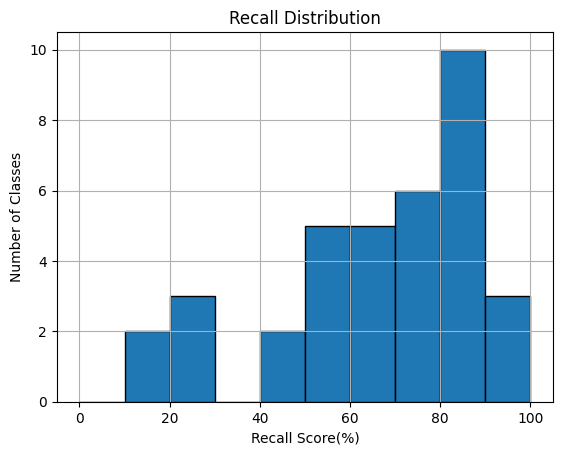

In [27]:
import pylab as pl

recall_dict = defaultdict()
for k,v in stat_dict.items():
    recall_dict[k] = v[2]

recall_list = []
for k,v in recall_dict.items():
    recall_list.append(v*100)
   
d = {'Recall': recall_list}
tinydf = pd.DataFrame(data=d)



hist = tinydf.hist(edgecolor='black', bins = [0,10,20,30,40,50,60,70,80,90,100])
pl.title("Recall Distribution")
pl.xlabel("Recall Score(%)")
pl.ylabel("Number of Classes")
print(tinydf)

## log_loss histogram

    logloss
0    0.2951
1    0.2169
2    0.3644
3    0.3465
4    0.3339
5    0.3722
6    0.2744
7    0.2691
8    0.2142
9    0.2675
10   0.1872
11   0.2653
12   0.3053
13   0.2460
14   0.2615
15   0.3920
16   0.3374
17   0.2289
18   0.2645
19   0.3150
20   0.2390
21   0.2065
22   0.4226
23   0.2327
24   0.2485
25   0.3188
26   0.4229
27   0.4034
28   0.2269
29   0.2149
30   0.2701
31   0.2104
32   0.1832
33   0.1727
34   0.3673
35   0.3207


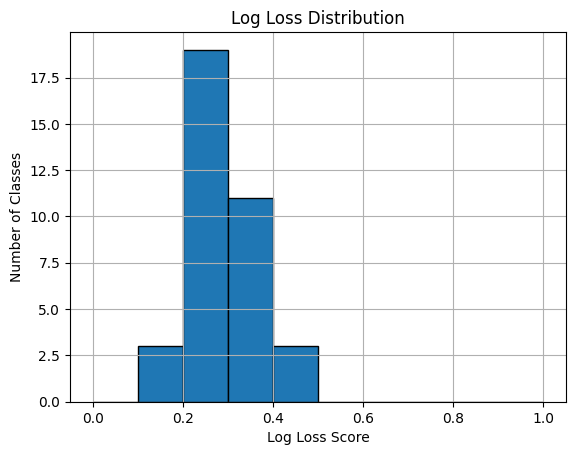

In [34]:
import pylab as pl

logloss_dict = defaultdict()
for k,v in stat_dict.items():
    logloss_dict[k] = v[5]

logloss_list = []
for k,v in logloss_dict.items():
    logloss_list.append(v)
   
d = {'logloss': logloss_list}
tinydf = pd.DataFrame(data=d)

hist = tinydf.hist(edgecolor='black', bins = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
pl.title("Log Loss Distribution")
pl.xlabel("Log Loss Score")
pl.ylabel("Number of Classes")
print(tinydf)

# Custom Input Prediction

In [44]:
text = "How do I get my mom's license taken away. My mom is 66, on disability for multiple sclerosis. She's been unable to work for about a decade. She has cataracts. She has neuropathy. She has 0 reaction time. She has had a fender bender on every single corner of her last car, which my brother then totaled. She also has no night vision. She also falls asleep all the time. ALMOST like like narcolepsy. It's mostly her overextending herself, but she will nod off driving or sleep in parking lots til she feels ok. She also has lymphedema in her legs which are swollen enough to impede driving. The last year she was driving she received 19 red light tickets. She agreed not to drive. And the insurance paid for her car. Now she's bought a new one, about 6 months later. Our relationship is terrible. I hate her. But I want her licence taken away before she kills or cripples someone(s). I'm no contact with her, but my brother still tries and he cares about this a lot. I've spoken with the DMV IN MY state, not very helpful. Can i contact her insurance? Do I contact the police? Has this happened to anyone"

print(text)
input = sent2vec(text)
input = np.array(input)

predictions = defaultdict() 
prob = defaultdict()
c_logloss = defaultdict()

for cls in class_list:
    predictions[cls] = classifier[cls].predict([input])
    prob[cls] = classifier[cls].predict_proba([input])

for k,v in predictions.items():   
    if v > 0:
        print(k, v, end = ' ')
        print(np.round(prob[k][0][1], 4))


How do I get my mom's license taken away. My mom is 66, on disability for multiple sclerosis. She's been unable to work for about a decade. She has cataracts. She has neuropathy. She has 0 reaction time. She has had a fender bender on every single corner of her last car, which my brother then totaled. She also has no night vision. She also falls asleep all the time. ALMOST like like narcolepsy. It's mostly her overextending herself, but she will nod off driving or sleep in parking lots til she feels ok. She also has lymphedema in her legs which are swollen enough to impede driving. The last year she was driving she received 19 red light tickets. She agreed not to drive. And the insurance paid for her car. Now she's bought a new one, about 6 months later. Our relationship is terrible. I hate her. But I want her licence taken away before she kills or cripples someone(s). I'm no contact with her, but my brother still tries and he cares about this a lot. I've spoken with the DMV IN MY stat